<a href="https://colab.research.google.com/github/mohammad-rahbari/Federated-Learning-MLDL/blob/master/notebooks/MLDL_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np

# Extract trained setting

In [50]:

def get_seed_models(df):
  filter = df['round_number'] == 0
  df_filtered = df[filter]
  return df_filtered

def get_model_squence(df, seed_model):
  seed_model_name = seed_model if isinstance(seed_model , str) else seed_model['model_name']
  result = df[df['model_name']==seed_model_name]
  latest_model = result['model_name'].values[0]
  while True:
    if latest_model in df['prev_global_model_name'].values:
      temp =  df[df['prev_global_model_name']==latest_model]
      latest_model = temp['model_name'].values[0]
      result = pd.concat([result, temp])
    else:
      break
  result = result.sort_values(by=['round_number'])
  return result

def get_from_client(df_client, model_name, attribute, single_record= True):
  if single_record:
    return df_client[df_client['initial_model_name']==model_name][attribute].values[0]
  else:
    return df_client[df_client['initial_model_name']==model_name][attribute]

def get_vlid_lst(lst):
  result = []
  for i in lst:

    if not (i is None or np.isnan(i)):
      result.append(i)

  return result

In [ ]:
df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
df_client = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")

seed_models = get_seed_models(df_global)
for i in range(len(seed_models)):

  log = f"{i+1})\n"


  df_seq = get_model_squence(df_global,seed_models.iloc[i] )
  r_num = max(get_vlid_lst(df_seq['round_number'].values))
  if r_num != 0:

    log +=f"Seed model: {seed_models.iloc[i]['model_name']} \n"
    log +=f"Spliting method: {df_seq['splitting_method'].values[-1]}  \n"
    if df_seq['splitting_method'].values[-1] == "non-i.i.d. sharing":
      log +=f"Nc: {max(get_vlid_lst(df_seq['Nc'].values))}  \n"
    log +=f"Number of rounds: {r_num}  \n"
    log +=f"Number of local_steps: {max(get_vlid_lst(df_seq['num_local_steps'].values))}  \n"
    try:
      log +=f"Target Sparcity: {get_from_client(df_client, seed_models.iloc[i]['model_name'], 'sparsity')}  \n"
    except:
      f"Target Sparcity: {0.5}  \n"
      pass
    log +=f"Accuracy: {df_seq[df_seq['round_number']== r_num]['accuracy'].values[-1]}  \n"
    log +=f"Loss: {df_seq[df_seq['round_number']== r_num]['loss'].values[-1]} \n"


    print(log," \n \n \n")







In [ ]:
df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")

model_name_to_update = "ba641ff5-2a41-49f9-bd49-07b0a9a595a3"
new_nc_value = 100
new_local_step_num_value = 8

# Update 'Nc' and 'num_local_steps' for the specified model name
df_global.loc[df_global['model_name'] == model_name_to_update, 'Nc'] = new_nc_value
df_global.loc[df_global['model_name'] == model_name_to_update, 'num_local_steps'] = new_local_step_num_value

# Display the updated rows to verify
display(df_global[df_global['model_name'] == model_name_to_update])

,backbone,num_of_clients,splitting_method,Nc,num_local_steps,aggregation_method,Measurement_criteria,accuracy,loss,size_of_dataset,...,round_number,num_of_participants,model_name,prev_global_model_name,contributors,path,momentum_vector_path,path_to_subsets,path_to_class_combs,time
654,dino_vits16,100,i.i.d. sharing,100.0,8.0,FedAvg,"accuracy,loss",47.13,2.006864,50000,...,50,10.0,ba641ff5-2a41-49f9-bd49-07b0a9a595a3,664e5fb4-d72f-437c-87e8-081869edb33a,"['7a3b3c3a-9bf2-4a06-aee6-4a0de9e7095d', '0f94...",/content/drive/MyDrive/MLDL_FederatedLearning/...,NaN,/content/drive/MyDrive/MLDL_FederatedLearning/...,NaN,2025-09-06 21:11:39


In [ ]:
df_global.to_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv", index=False)

In [55]:
modename_targetround= {
    "3b16bcde-abf5-4c87-b9bb-ef2827a59c6d":25,
    "1f7efd38-b55a-458c-9478-b763895e5acc":25,
    "165b689b-6b5e-48eb-9d24-ae343a039013":25,
    "0af55aa3-0139-49aa-95c4-854a511ad30d":25,
    "3fba6992-552f-420f-877f-82afd3f0ef6f":50,
    "f77e86b0-b0e3-4cd8-b65a-40323e81b49b":50,
    "fdb2734f-a092-4641-a843-969dcc993937":100,
    "91be5aaa-6416-4558-89d4-a8c18e6d1e2f":50,
    "0decec9d-3280-48d6-8c4e-ad1785b9736e":50,
    "f60e06e4-ac4b-4495-8904-16753c21c425":25,
    "453429aa-5c7f-4046-b4f2-658588fc9c38":25,
    "201a5aeb-0d1e-438f-8178-4ebcc4d94435":50,
    "23f056c6-52e9-47b2-beb1-9ef590f743cc":100,
    "61cb31ef-74c1-4f60-95e9-d35fd60a7d55":100,
    "f56d4e15-9536-4733-9120-6423230a650d":100,
    "f142f936-1ed1-4dfb-b0b2-3f99aff46a89":100,
    "612d19a1-3b97-466f-a17f-892ce36bd5c9":25
    }
data_for_new_df = []

df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
df_client = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")



seed_models = get_seed_models(df_global)
for i in range(len(seed_models)):
  df_seq = get_model_squence(df_global,seed_models.iloc[i] )
  seed_name = seed_models.iloc[i]['model_name']
  if seed_name not in modename_targetround.keys():
    continue
  record = df_seq[df_seq["round_number"]==modename_targetround[seed_name]]
  sparsity =  get_from_client(df_client, seed_models.iloc[i]['model_name'], 'sparsity') if seed_name != "612d19a1-3b97-466f-a17f-892ce36bd5c9" else 0.5

  splitting_method =  record['splitting_method'].values[0]
  splitting_method =splitting_method.replace(" sharing", "")

  data_for_new_df.append({

        'round_number': record['round_number'].values[0],
        'local_step': int(record['num_local_steps'].values[-1]),
        'sparsity': sparsity,
        'Nc': int(record['Nc'].values[-1]),
        'accuracy': record['accuracy'].values[0],
        'loss': record['loss'].values[0],
        'aggregation_method' : record["aggregation_method"].values[0],
        'spliting_method':splitting_method,
        'seed_model_name': seed_name,
        'last_model_name': record["model_name"].values[0]

    })


result_df = pd.DataFrame(data_for_new_df)


display(result_df)

,round_number,local_step,sparsity,Nc,accuracy,loss,aggregation_method,spliting_method,seed_model_name,last_model_name
0,100,4,0.5,100,37.55,2.509509,FedAvg,i.i.d.,f142f936-1ed1-4dfb-b0b2-3f99aff46a89,900f32b7-9a03-4eaf-b252-feaa8944678d
1,100,4,0.5,50,42.89,2.220242,FedAvg,non-i.i.d.,f56d4e15-9536-4733-9120-6423230a650d,6f243790-ba8b-4bf0-8fdc-15ca06b78067
2,100,4,0.5,10,42.20,2.311263,FedAvg,non-i.i.d.,61cb31ef-74c1-4f60-95e9-d35fd60a7d55,d061c76f-18ab-4e8b-b2df-7392c9cdb8c6
3,100,4,0.5,5,36.99,2.483904,FedAvg,non-i.i.d.,23f056c6-52e9-47b2-beb1-9ef590f743cc,766ea6e6-f387-4939-b06f-a92141f40947
4,50,8,0.5,100,47.13,2.006864,FedAvg,i.i.d.,201a5aeb-0d1e-438f-8178-4ebcc4d94435,ba641ff5-2a41-49f9-bd49-07b0a9a595a3
5,25,16,0.5,100,54.13,1.704356,FedAvg,i.i.d.,612d19a1-3b97-466f-a17f-892ce36bd5c9,96e69034-1f33-4cb4-af98-5fedc9223e2d
6,25,16,0.5,50,55.72,1.633388,FedAvg,non-i.i.d.,453429aa-5c7f-4046-b4f2-658588fc9c38,afda943f-f16c-432a-ac3f-049d507f9ba3
7,25,16,0.5,1,9.38,6.838218,FedAvg,non-i.i.d.,f60e06e4-ac4b-4495-8904-16753c21c425,81667e00-23ee-4ff7-965d-2965bd0fb750
8,50,8,0.5,50,51.73,1.817291,FedAvg,non-i.i.d.,0decec9d-3280-48d6-8c4e-ad1785b9736e,94781c1d-c50e-4ec9-afd2-358a0f6850c6
9,50,8,0.5,10,45.61,2.107623,FedAvg,non-i.i.d.,91be5aaa-6416-4558-89d4-a8c18e6d1e2f,f48789e6-5511-4885-b57f-563bccb93d2b


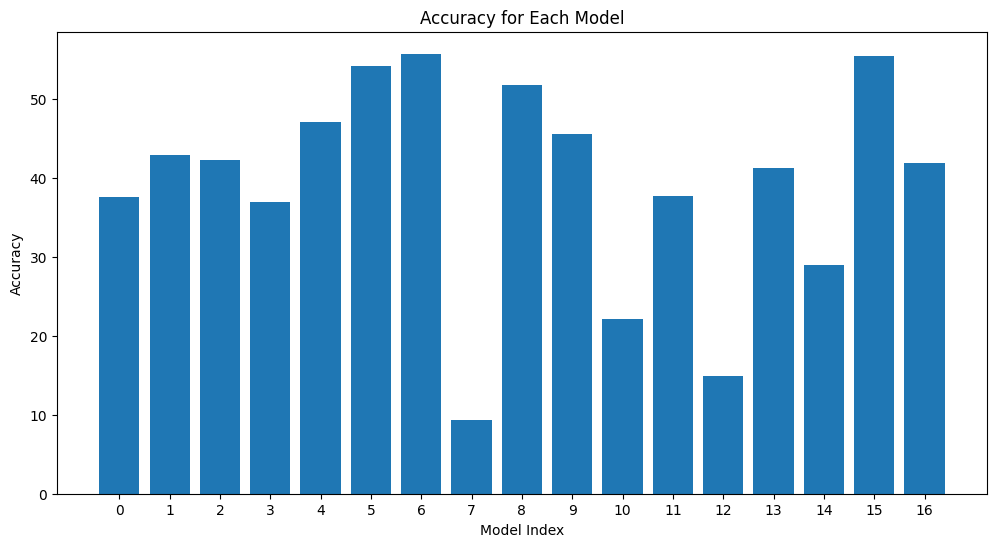

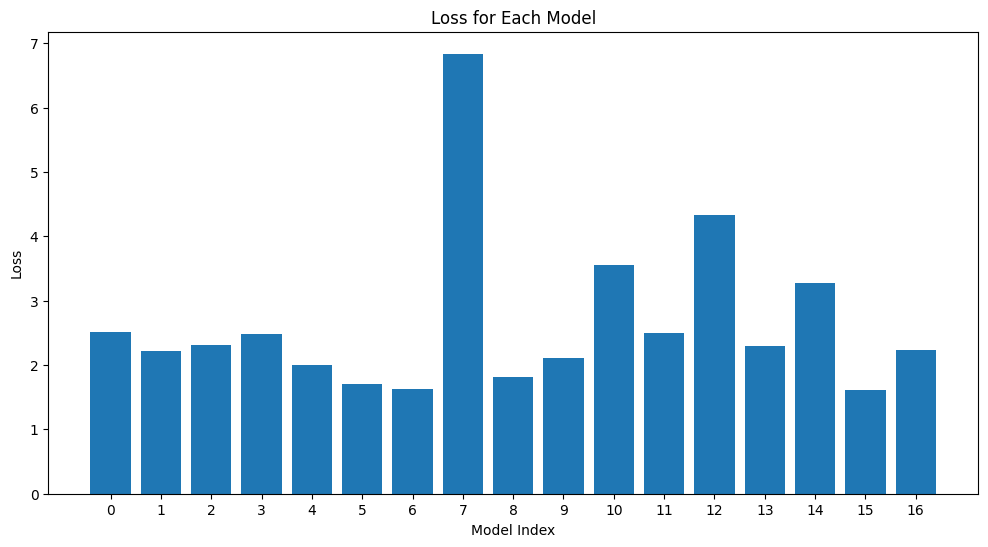

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart for accuracy
plt.figure(figsize=(12, 6))
plt.bar(result_df.index, result_df['accuracy'])
plt.xlabel('Model Index')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Model')
plt.xticks(result_df.index)
plt.show()

# Create a bar chart for loss
plt.figure(figsize=(12, 6))
plt.bar(result_df.index, result_df['loss'])
plt.xlabel('Model Index')
plt.ylabel('Loss')
plt.title('Loss for Each Model')
plt.xticks(result_df.index)
plt.show()

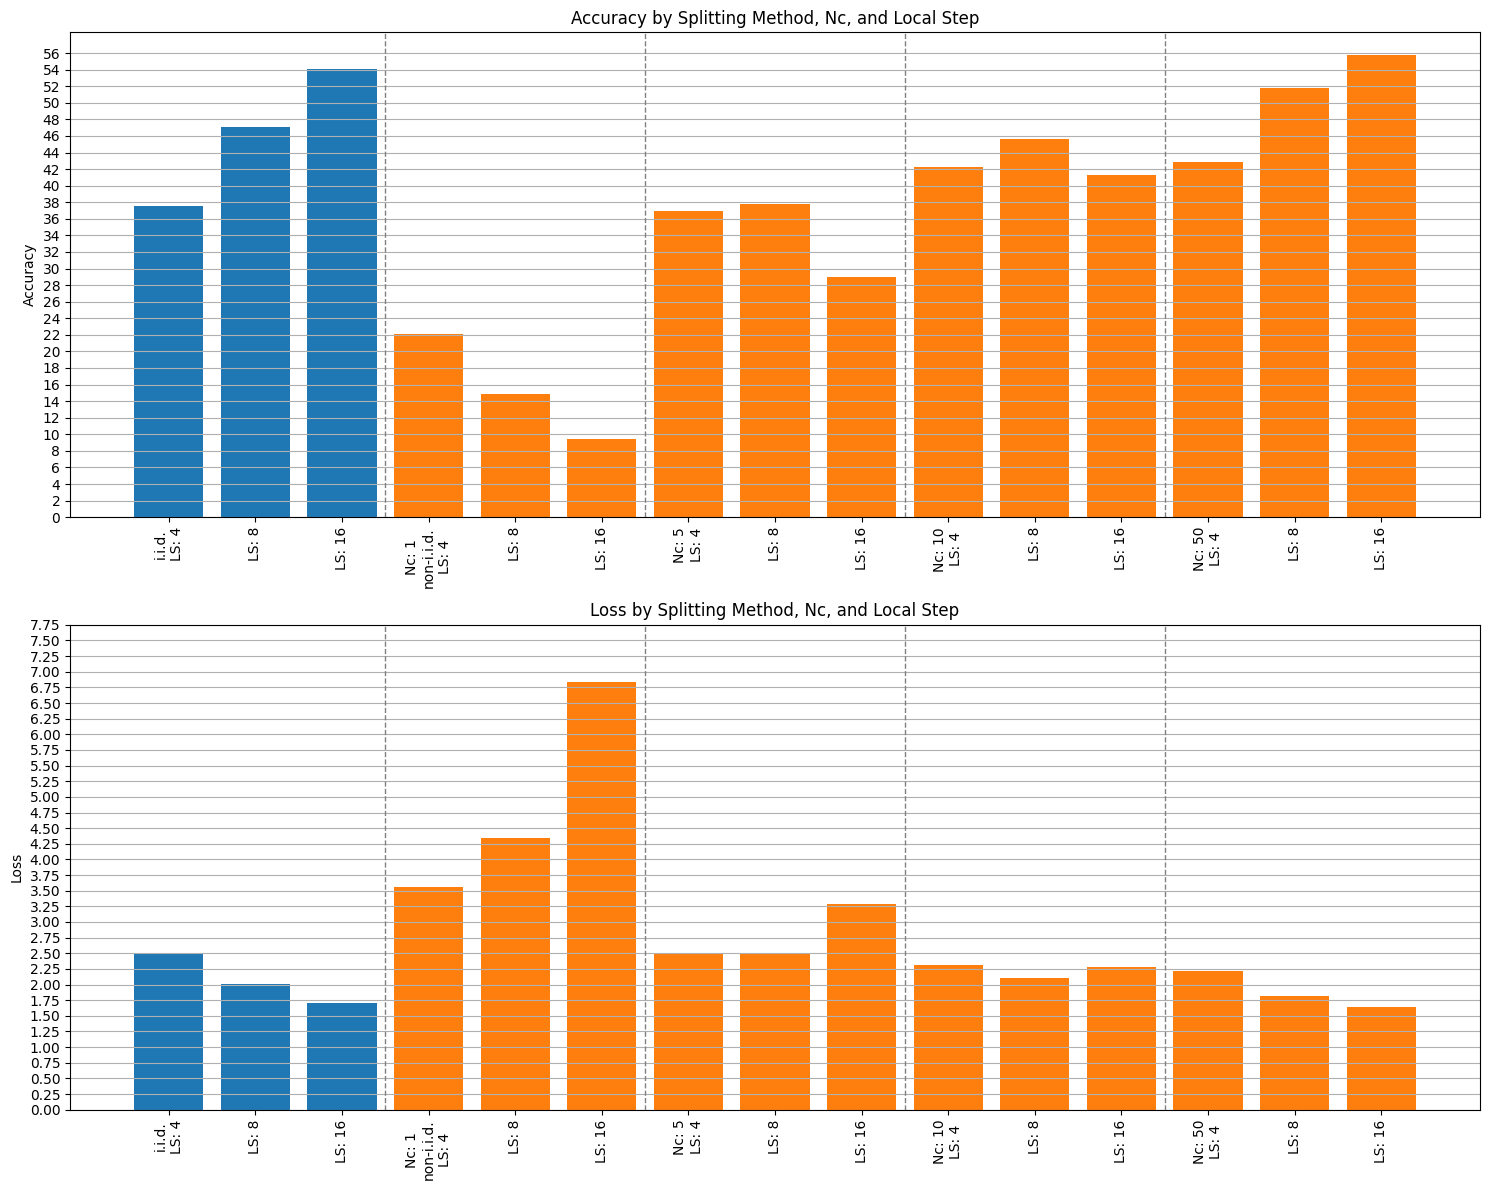

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

result_df = result_df[result_df['sparsity']== 0.5]
# Separate i.i.d. and non-i.i.d. data
iid_df = result_df[result_df['spliting_method'] == 'i.i.d.'].sort_values(by='local_step')
non_iid_df = result_df[result_df['spliting_method'] == 'non-i.i.d.'].sort_values(by=['Nc', 'local_step'])

# Combine the dataframes with i.i.d. first
result_df_sorted = pd.concat([iid_df, non_iid_df])

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Get unique splitting methods for coloring
unique_splitting_methods = result_df_sorted['spliting_method'].unique()
color_map = dict(zip(unique_splitting_methods, sns.color_palette('tab10', len(unique_splitting_methods))))

# Plot Accuracy
ax1 = axes[0]
colors_accuracy = result_df_sorted['spliting_method'].map(color_map)
bars1 = ax1.bar(np.arange(len(result_df_sorted)), result_df_sorted['accuracy'], color=colors_accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Splitting Method, Nc, and Local Step')
ax1.set_xticks([]) # Hide default x-axis ticks
ax1.set_yticks(np.arange(0, max(result_df_sorted['accuracy'])+1, 2)) # Hide default x-axis ticks

# Add custom x-axis labels and separators
label_positions = []
labels = []
separator_positions = []
current_split_method = None
current_nc = None

for i, row in result_df_sorted.reset_index().iterrows():
    label = f'LS: {int(row["local_step"])}'
    label_positions.append(i)
    labels.append(label)

    if row['spliting_method'] != current_split_method:
        if current_split_method is not None:
            separator_positions.append(i - 0.5) # Add separator before a new splitting method group
        current_split_method = row['spliting_method']
        labels[-1] = f'{row["spliting_method"]}\n' + labels[-1] # Add splitting method to label
        current_nc = None # Reset Nc for the new splitting method

    if row['spliting_method'] == 'non-i.i.d.' and row['Nc'] != current_nc:
        if current_nc is not None:
             separator_positions.append(i - 0.5) # Add separator before a new Nc group
        current_nc = row['Nc']
        labels[-1] = f'Nc: {int(row["Nc"])}\n' + labels[-1] # Add Nc to label


ax1.set_xticks(label_positions)
ax1.set_xticklabels(labels, rotation=90)
ax1.grid(axis='y')
for pos in separator_positions:
    ax1.axvline(x=pos, color='gray', linestyle='--', linewidth=1)


# Plot Loss
ax2 = axes[1]
colors_loss = result_df_sorted['spliting_method'].map(color_map)
bars2 = ax2.bar(np.arange(len(result_df_sorted)), result_df_sorted['loss'], color=colors_loss)
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Splitting Method, Nc, and Local Step')
ax2.set_xticks([]) # Hide default x-axis ticks
ax2.set_yticks(np.arange(0, max(result_df_sorted['loss'])+1, 0.25)) # Hide default x-axis ticks

# Add custom x-axis labels and separators
label_positions = []
labels = []
separator_positions = []
current_split_method = None
current_nc = None

for i, row in result_df_sorted.reset_index().iterrows():
    label = f'LS: {int(row["local_step"])}'
    label_positions.append(i)
    labels.append(label)

    if row['spliting_method'] != current_split_method:
        if current_split_method is not None:
            separator_positions.append(i - 0.5) # Add separator before a new splitting method group
        current_split_method = row['spliting_method']
        labels[-1] = f'{row["spliting_method"]}\n' + labels[-1] # Add splitting method to label
        current_nc = None # Reset Nc for the new splitting method

    if row['spliting_method'] == 'non-i.i.d.' and row['Nc'] != current_nc:
        if current_nc is not None:

             separator_positions.append(i - 0.5) # Add separator before a new Nc group
        current_nc = row['Nc']
        labels[-1] = f'Nc: {int(row["Nc"])}\n' + labels[-1] # Add Nc to label
ax2.grid(axis='y')
ax2.set_xticks(label_positions)
ax2.set_xticklabels(labels, rotation=90)

for pos in separator_positions:
    ax2.axvline(x=pos, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
# plt.show()
plt.savefig("Accuracy and Loss by Splitting Method, Nc, and Local Step.pdf")

In [ ]:
result_df = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/result_df.csv")

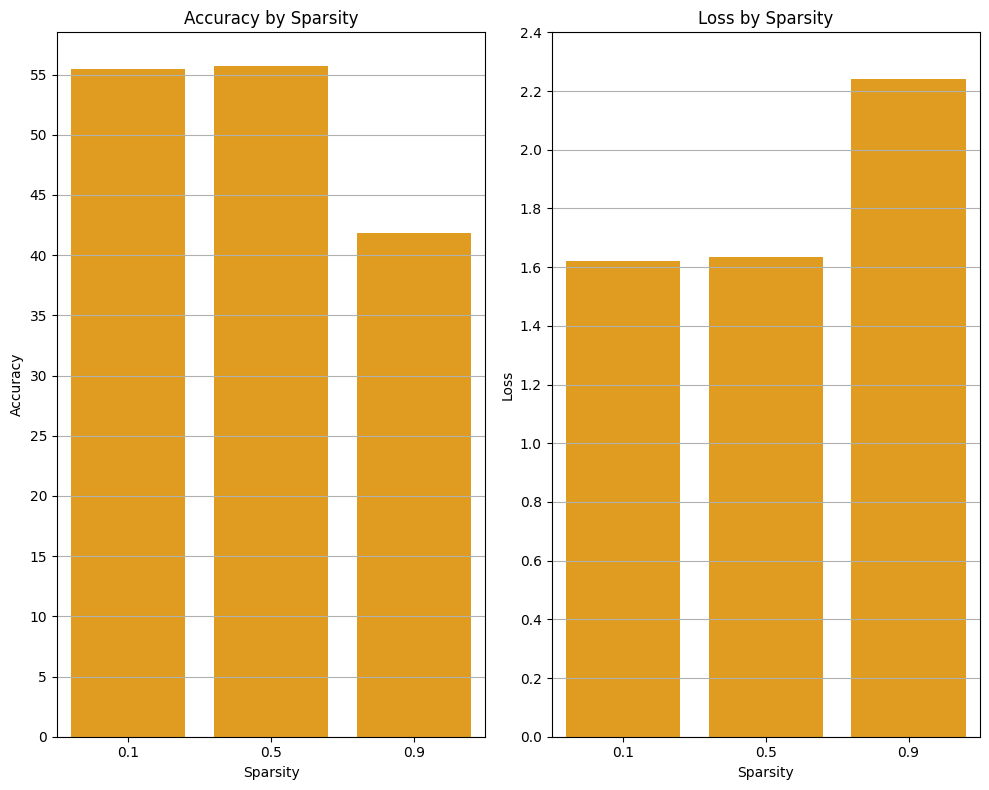

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of model names to filter by
target_models = ['83bd0a91-3c99-4fc9-b8e6-c13d3c6cdff0', 'afda943f-f16c-432a-ac3f-049d507f9ba3', 'a63ef45b-271e-4c54-8be8-c7c97b24e1ba']

# Filter the result_df for the target models and sort by sparsity
filtered_df = result_df[result_df['last_model_name'].isin(target_models)].sort_values(by='sparsity')

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Bar chart for Accuracy
sns.barplot(x='sparsity', y='accuracy', data=filtered_df, ax=axes[0], color="orange")
axes[0].set_title('Accuracy by Sparsity')
axes[0].set_xlabel('Sparsity')
axes[0].set_ylabel('Accuracy')
axes[0].grid(axis='y')
axes[0].set_yticks(np.arange(0, max(filtered_df['accuracy'].values)+1, 5))
# Bar chart for Loss
sns.barplot(x='sparsity', y='loss', data=filtered_df, ax=axes[1], color="orange")
axes[1].set_title('Loss by Sparsity')
axes[1].set_xlabel('Sparsity')
axes[1].set_ylabel('Loss')
axes[1].grid(axis='y')
axes[1].set_yticks(np.arange(0, max(filtered_df['loss'].values)+0.2, 0.2))

plt.tight_layout()
plt.savefig("Accuracy and Loss by Sparsity.pdf")

# plt.show()

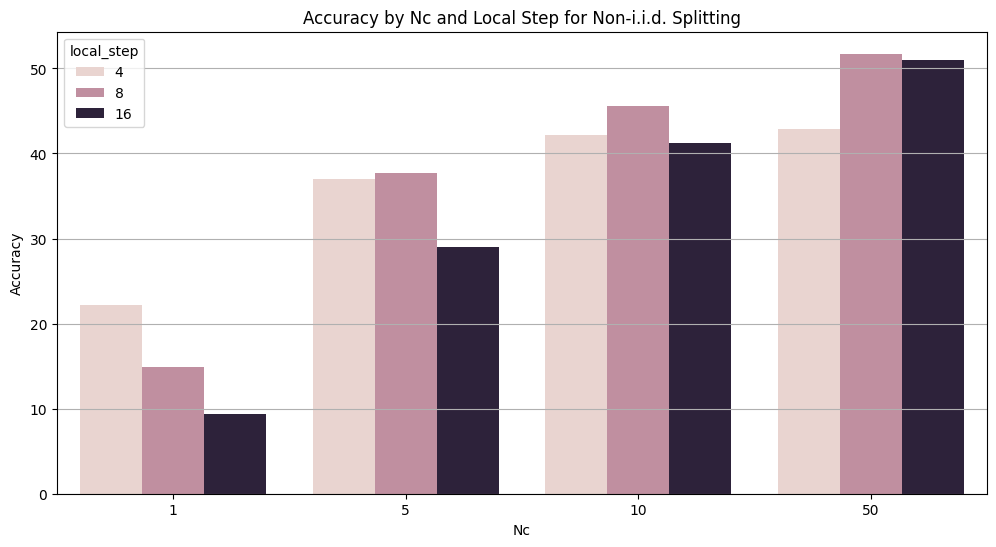

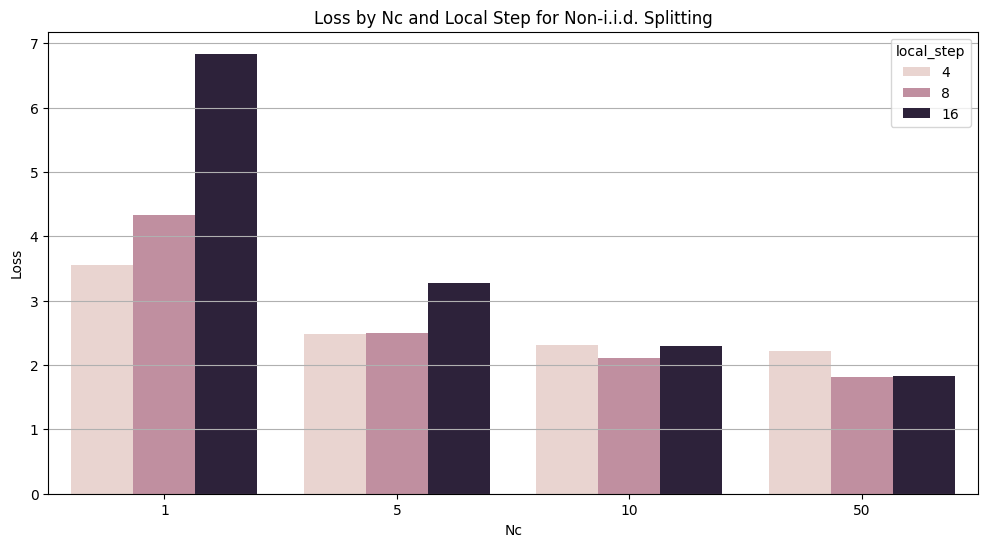

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for non-i.i.d. records
non_iid_df = result_df[result_df['spliting_method'] == 'non-i.i.d.']

# Create a grouped bar chart for Accuracy showing exact values
plt.figure(figsize=(12, 6))
sns.barplot(x='Nc', y='accuracy', hue='local_step', data=non_iid_df, errorbar=None) # errorbar=None to show individual bars

plt.title('Accuracy by Nc and Local Step for Non-i.i.d. Splitting')
plt.xlabel('Nc')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

# Create a grouped bar chart for Loss showing exact values
plt.figure(figsize=(12, 6))
sns.barplot(x='Nc', y='loss', hue='local_step', data=non_iid_df, errorbar=None) # errorbar=None to show individual bars
plt.title('Loss by Nc and Local Step for Non-i.i.d. Splitting')
plt.xlabel('Nc')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.show()

In [13]:
global_df1 = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
global_df2 = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_logxin.csv")
global_df = pd.concat([global_df1, global_df2])

clien_df1 = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")
clien_df2 = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_logxin.csv")
clien_df = pd.concat([clien_df1, clien_df2])

In [88]:
modename_targetround= {
    "3b16bcde-abf5-4c87-b9bb-ef2827a59c6d":25,
    "1f7efd38-b55a-458c-9478-b763895e5acc":25,
    "165b689b-6b5e-48eb-9d24-ae343a039013":25,
    "0af55aa3-0139-49aa-95c4-854a511ad30d":25,
    "3fba6992-552f-420f-877f-82afd3f0ef6f":50,
    "f77e86b0-b0e3-4cd8-b65a-40323e81b49b":50,
    "fdb2734f-a092-4641-a843-969dcc993937":100,
    "91be5aaa-6416-4558-89d4-a8c18e6d1e2f":50,
    "0decec9d-3280-48d6-8c4e-ad1785b9736e":50,
    "f60e06e4-ac4b-4495-8904-16753c21c425":25,
    "453429aa-5c7f-4046-b4f2-658588fc9c38":25,
    "201a5aeb-0d1e-438f-8178-4ebcc4d94435":50,
    "23f056c6-52e9-47b2-beb1-9ef590f743cc":100,
    "61cb31ef-74c1-4f60-95e9-d35fd60a7d55":100,
    "f56d4e15-9536-4733-9120-6423230a650d":100,
    "f142f936-1ed1-4dfb-b0b2-3f99aff46a89":100,
    "612d19a1-3b97-466f-a17f-892ce36bd5c9":25,
    "f5f1e9d4-0763-4c83-b861-d85183bb843e":25,
    "fcfd4448-0919-48ed-a4a1-3ae1082d4c1e":100,
    "f8f2308a-c255-4921-9865-7ee771de3681":100,
    "1cc33d9b-82f2-482e-9025-99bcaaa2bfa9":100,
    "efe6e04e-1eea-479f-8518-7dedeab98e54":100,
    "1fe01e6b-3ef8-4749-b994-0189e9206b4f":100,
    "46ec5997-c229-4b5a-933b-49d8efc79462":50,
    "8525bb82-0edf-40ed-a947-f39a1d35ecba":25,
    "d574205b-ed70-4406-a597-41f72d91eac6":25,
    "c94306a2-bbde-4cfb-a907-2bb0375519aa":25,
    "671e7028-eca0-441e-8398-6c0be48e4815":25,
    "2fec0734-f351-4e13-a5d4-b6c7898414eb":50,
    "d6481fe5-abb2-451f-938a-37a85d52cad2":50,
    "b899e61b-de05-4864-a2de-8d29f67b447f":50,
    "40103bf2-a9bf-49dd-a27f-c4f4a9962b9c":50,
    "e71a925c-8fc6-48dd-9080-cb627d523dbb":25,
    "c03daddc-4535-4a69-92e9-967f7185c519":25,
    "4b94d332-b21c-4e2b-af6f-f7801a35fc4c":25,
    "6741f67c-7c82-494c-ad1e-213923d385e7":50,
    "97bf469e-a87e-4a81-b6ad-2d917ca4e925":50



    }
data_for_new_df = []

# df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
# df_client = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")



seed_models = get_seed_models(global_df)
for i in range(len(seed_models)):
  df_seq = get_model_squence(global_df,seed_models.iloc[i] )
  seed_name = seed_models.iloc[i]['model_name']
  if seed_name not in modename_targetround.keys():
    continue
  record = df_seq[df_seq["round_number"]==modename_targetround[seed_name]-1]

  sparsity =  get_from_client(clien_df, seed_models.iloc[i]['model_name'], 'sparsity') if seed_name != "612d19a1-3b97-466f-a17f-892ce36bd5c9" else 0.5

  splitting_method =  record['splitting_method'].values[0]
  splitting_method =splitting_method.replace(" sharing", "")

  data_for_new_df.append({

        'round_number': record['round_number'].values[0],
        'local_step': int(record['num_local_steps'].values[-1]),
        'sparsity': sparsity,
        'Nc': int(record['Nc'].values[-1])  if  splitting_method != "i.i.d." else 100 ,
        'accuracy': record['accuracy'].values[0],
        'loss': record['loss'].values[0],
        'aggregation_method' : record["aggregation_method"].values[0],
        'spliting_method':splitting_method,
        'seed_model_name': seed_name,
        'last_model_name': record["model_name"].values[0]

    })


result_df = pd.DataFrame(data_for_new_df)


display(result_df)

,round_number,local_step,sparsity,Nc,accuracy,loss,aggregation_method,spliting_method,seed_model_name,last_model_name
0,99,4,0.5,100,37.00,2.527023,FedAvg,i.i.d.,f142f936-1ed1-4dfb-b0b2-3f99aff46a89,7881bf98-380c-4310-9de4-fa8532579c06
1,99,4,0.5,50,42.54,2.225097,FedAvg,non-i.i.d.,f56d4e15-9536-4733-9120-6423230a650d,d27f80d1-e3c6-444e-b9a7-627fffcb178b
2,99,4,0.5,10,41.66,2.348213,FedAvg,non-i.i.d.,61cb31ef-74c1-4f60-95e9-d35fd60a7d55,174aef98-c6e2-466e-a58f-1af28b9c2fbe
3,99,4,0.5,5,37.34,2.486749,FedAvg,non-i.i.d.,23f056c6-52e9-47b2-beb1-9ef590f743cc,1a524277-23f0-4ce7-8bab-4e14da58a420
4,49,8,0.5,100,46.62,2.023373,FedAvg,i.i.d.,201a5aeb-0d1e-438f-8178-4ebcc4d94435,664e5fb4-d72f-437c-87e8-081869edb33a
5,24,16,0.5,100,53.50,1.728103,FedAvg,i.i.d.,612d19a1-3b97-466f-a17f-892ce36bd5c9,da18ed4a-4f0b-4e63-ac40-8558746b31ac
6,24,16,0.5,50,54.92,1.655675,FedAvg,non-i.i.d.,453429aa-5c7f-4046-b4f2-658588fc9c38,bb6ad970-dd6b-49b6-a960-1c912df5fc03
7,24,16,0.5,1,10.15,6.714367,FedAvg,non-i.i.d.,f60e06e4-ac4b-4495-8904-16753c21c425,8008fe6d-08b8-4ba1-8055-3f2418470710
8,49,8,0.5,50,51.13,1.822971,FedAvg,non-i.i.d.,0decec9d-3280-48d6-8c4e-ad1785b9736e,a809aea2-11e9-4b19-bedb-cafb57b39caa
9,49,8,0.5,10,45.74,2.113562,FedAvg,non-i.i.d.,91be5aaa-6416-4558-89d4-a8c18e6d1e2f,2164dd19-7c3c-4ce3-9674-1d10079be204


In [189]:
fedavg_nomasking_df = result_df[result_df['aggregation_method'] == 'FedAvg_noMasking']
fedavg_nomasking_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
fedavg_nomasking_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method","sparsity"], inplace=True)
fedavg_nomasking_df['round_number'] +=1
display(fedavg_nomasking_df)
print(fedavg_nomasking_df.to_latex())

Index(['round_number', 'local_step', 'Nc', 'accuracy', 'loss',
       'spliting_method'],
      dtype='object')


/tmp/ipython-input-1509164088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fedavg_nomasking_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
/tmp/ipython-input-1509164088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fedavg_nomasking_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method","sparsity"], inplace=True)
/tmp/ipython-input-1509164088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,round_number,local_step,Nc,accuracy,loss,spliting_method
35,100,4,1,20.78,3.608788,non-i.i.d.
27,50,8,1,16.55,4.203982,non-i.i.d.
24,25,16,1,10.89,6.492585,non-i.i.d.
34,100,4,5,37.29,2.517697,non-i.i.d.
28,50,8,5,38.48,2.609044,non-i.i.d.
23,25,16,5,29.61,3.101865,non-i.i.d.
33,100,4,10,40.81,2.327836,non-i.i.d.
29,50,8,10,43.96,2.152247,non-i.i.d.
30,25,16,10,40.52,2.383465,non-i.i.d.
32,100,4,50,43.94,2.182856,non-i.i.d.


\begin{tabular}{lrrrrrl}
\toprule
 & round_number & local_step & Nc & accuracy & loss & spliting_method \\
\midrule
35 & 100 & 4 & 1 & 20.780000 & 3.608788 & non-i.i.d. \\
27 & 50 & 8 & 1 & 16.550000 & 4.203982 & non-i.i.d. \\
24 & 25 & 16 & 1 & 10.890000 & 6.492585 & non-i.i.d. \\
34 & 100 & 4 & 5 & 37.290000 & 2.517697 & non-i.i.d. \\
28 & 50 & 8 & 5 & 38.480000 & 2.609044 & non-i.i.d. \\
23 & 25 & 16 & 5 & 29.610000 & 3.101865 & non-i.i.d. \\
33 & 100 & 4 & 10 & 40.810000 & 2.327836 & non-i.i.d. \\
29 & 50 & 8 & 10 & 43.960000 & 2.152247 & non-i.i.d. \\
30 & 25 & 16 & 10 & 40.520000 & 2.383465 & non-i.i.d. \\
32 & 100 & 4 & 50 & 43.940000 & 2.182856 & non-i.i.d. \\
26 & 50 & 8 & 50 & 52.000000 & 1.808881 & non-i.i.d. \\
25 & 25 & 16 & 50 & 55.240000 & 1.629005 & non-i.i.d. \\
31 & 100 & 4 & 100 & 44.520000 & 2.157522 & i.i.d. \\
36 & 50 & 8 & 100 & 52.750000 & 1.768591 & i.i.d. \\
22 & 25 & 16 & 100 & 58.210000 & 1.518932 & i.i.d. \\
\bottomrule
\end{tabular}



In [190]:
fedavg_df = result_df[result_df['aggregation_method'] == 'FedAvg']
fedavg_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
fedavg_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method"], inplace=True)
fedavg_df['round_number'] +=1
display(fedavg_df)
print(fedavg_df.to_latex())

/tmp/ipython-input-1851329831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fedavg_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
/tmp/ipython-input-1851329831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fedavg_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method"], inplace=True)
/tmp/ipython-input-1851329831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,round_number,local_step,sparsity,Nc,accuracy,loss,spliting_method
10,100,4,0.5,1,20.74,3.633295,non-i.i.d.
12,50,8,0.5,1,16.68,4.329040,non-i.i.d.
7,25,16,0.5,1,10.15,6.714367,non-i.i.d.
3,100,4,0.5,5,37.34,2.486749,non-i.i.d.
11,50,8,0.5,5,37.54,2.527585,non-i.i.d.
14,25,16,0.5,5,31.56,3.159031,non-i.i.d.
2,100,4,0.5,10,41.66,2.348213,non-i.i.d.
9,50,8,0.5,10,45.74,2.113562,non-i.i.d.
13,25,16,0.5,10,41.52,2.303642,non-i.i.d.
1,100,4,0.5,50,42.54,2.225097,non-i.i.d.


\begin{tabular}{lrrrrrrl}
\toprule
 & round_number & local_step & sparsity & Nc & accuracy & loss & spliting_method \\
\midrule
10 & 100 & 4 & 0.500000 & 1 & 20.740000 & 3.633295 & non-i.i.d. \\
12 & 50 & 8 & 0.500000 & 1 & 16.680000 & 4.329040 & non-i.i.d. \\
7 & 25 & 16 & 0.500000 & 1 & 10.150000 & 6.714367 & non-i.i.d. \\
3 & 100 & 4 & 0.500000 & 5 & 37.340000 & 2.486749 & non-i.i.d. \\
11 & 50 & 8 & 0.500000 & 5 & 37.540000 & 2.527585 & non-i.i.d. \\
14 & 25 & 16 & 0.500000 & 5 & 31.560000 & 3.159031 & non-i.i.d. \\
2 & 100 & 4 & 0.500000 & 10 & 41.660000 & 2.348213 & non-i.i.d. \\
9 & 50 & 8 & 0.500000 & 10 & 45.740000 & 2.113562 & non-i.i.d. \\
13 & 25 & 16 & 0.500000 & 10 & 41.520000 & 2.303642 & non-i.i.d. \\
1 & 100 & 4 & 0.500000 & 50 & 42.540000 & 2.225097 & non-i.i.d. \\
8 & 50 & 8 & 0.500000 & 50 & 51.130000 & 1.822971 & non-i.i.d. \\
6 & 25 & 16 & 0.500000 & 50 & 54.920000 & 1.655675 & non-i.i.d. \\
15 & 25 & 16 & 0.100000 & 50 & 55.170000 & 1.661341 & non-i.i.d. \\
16 & 

In [191]:
globalmasking_df = result_df[result_df['aggregation_method'] == 'FedAvg']
globalmasking_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
globalmasking_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method"], inplace=True)
globalmasking_df['round_number'] +=1
display(globalmasking_df)
print(globalmasking_df.to_latex())

/tmp/ipython-input-1312229926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalmasking_df.sort_values(by=['Nc', 'local_step','spliting_method'], inplace=True)
/tmp/ipython-input-1312229926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalmasking_df.drop(columns=['seed_model_name','last_model_name',"aggregation_method"], inplace=True)
/tmp/ipython-input-1312229926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,round_number,local_step,sparsity,Nc,accuracy,loss,spliting_method
10,100,4,0.5,1,20.74,3.633295,non-i.i.d.
12,50,8,0.5,1,16.68,4.329040,non-i.i.d.
7,25,16,0.5,1,10.15,6.714367,non-i.i.d.
3,100,4,0.5,5,37.34,2.486749,non-i.i.d.
11,50,8,0.5,5,37.54,2.527585,non-i.i.d.
14,25,16,0.5,5,31.56,3.159031,non-i.i.d.
2,100,4,0.5,10,41.66,2.348213,non-i.i.d.
9,50,8,0.5,10,45.74,2.113562,non-i.i.d.
13,25,16,0.5,10,41.52,2.303642,non-i.i.d.
1,100,4,0.5,50,42.54,2.225097,non-i.i.d.


\begin{tabular}{lrrrrrrl}
\toprule
 & round_number & local_step & sparsity & Nc & accuracy & loss & spliting_method \\
\midrule
10 & 100 & 4 & 0.500000 & 1 & 20.740000 & 3.633295 & non-i.i.d. \\
12 & 50 & 8 & 0.500000 & 1 & 16.680000 & 4.329040 & non-i.i.d. \\
7 & 25 & 16 & 0.500000 & 1 & 10.150000 & 6.714367 & non-i.i.d. \\
3 & 100 & 4 & 0.500000 & 5 & 37.340000 & 2.486749 & non-i.i.d. \\
11 & 50 & 8 & 0.500000 & 5 & 37.540000 & 2.527585 & non-i.i.d. \\
14 & 25 & 16 & 0.500000 & 5 & 31.560000 & 3.159031 & non-i.i.d. \\
2 & 100 & 4 & 0.500000 & 10 & 41.660000 & 2.348213 & non-i.i.d. \\
9 & 50 & 8 & 0.500000 & 10 & 45.740000 & 2.113562 & non-i.i.d. \\
13 & 25 & 16 & 0.500000 & 10 & 41.520000 & 2.303642 & non-i.i.d. \\
1 & 100 & 4 & 0.500000 & 50 & 42.540000 & 2.225097 & non-i.i.d. \\
8 & 50 & 8 & 0.500000 & 50 & 51.130000 & 1.822971 & non-i.i.d. \\
6 & 25 & 16 & 0.500000 & 50 & 54.920000 & 1.655675 & non-i.i.d. \\
15 & 25 & 16 & 0.100000 & 50 & 55.170000 & 1.661341 & non-i.i.d. \\
16 & 

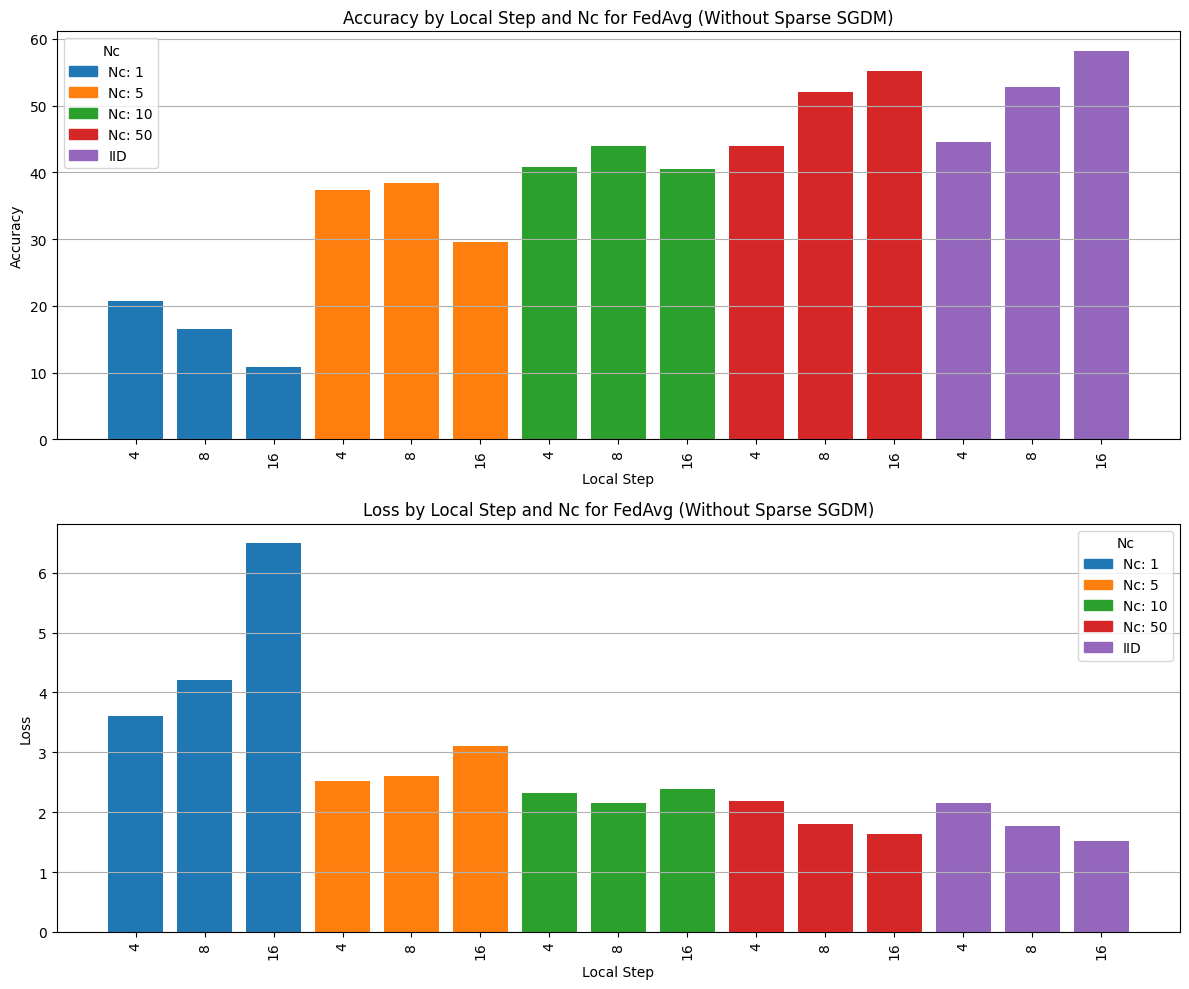

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for FedAvg_noMasking records
fedavg_nomasking_df = result_df[result_df['aggregation_method'] == 'FedAvg_noMasking']

# Sort by Nc and then local_step
fedavg_nomasking_df = fedavg_nomasking_df.sort_values(by=['Nc', 'local_step'])

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Get unique Nc values for coloring
unique_ncs = fedavg_nomasking_df['Nc'].unique()
color_map = dict(zip(unique_ncs, sns.color_palette('tab10', len(unique_ncs))))

# Plot Accuracy
ax1 = axes[0]
colors_accuracy = fedavg_nomasking_df['Nc'].map(color_map)
bars1 = ax1.bar(np.arange(len(fedavg_nomasking_df)), fedavg_nomasking_df['accuracy'], color=colors_accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Local Step and Nc for FedAvg_noMasking')
ax1.set_xticks(np.arange(len(fedavg_nomasking_df))) # Set x-ticks for each bar
ax1.set_xticklabels(fedavg_nomasking_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax1.set_xlabel('Local Step')
ax1.grid(axis='y')

# Add custom legend labels
legend_labels = [f'Nc: {int(nc)}' if nc != 100 else 'IID' for nc in unique_ncs]
legend_handles = [plt.Rectangle((0,0),1,1, color=color_map[nc]) for nc in unique_ncs]
ax1.legend(legend_handles, legend_labels, title="Nc")


# Plot Loss
ax2 = axes[1]
colors_loss = fedavg_nomasking_df['Nc'].map(color_map)
bars2 = ax2.bar(np.arange(len(fedavg_nomasking_df)), fedavg_nomasking_df['loss'], color=colors_loss)
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Local Step and Nc for FedAvg (Without Sparse SGDM)')
ax2.set_xticks(np.arange(len(fedavg_nomasking_df))) # Set x-ticks for each bar
ax2.set_xticklabels(fedavg_nomasking_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax2.set_xlabel('Local Step')
ax2.grid(axis='y')

# Add custom legend labels
ax2.legend(legend_handles, legend_labels, title="Nc")


plt.tight_layout()
plt.savefig("accuracy and Loss by Local Step and Nc for FedAvg (Without Sparse SGDM).pdf")

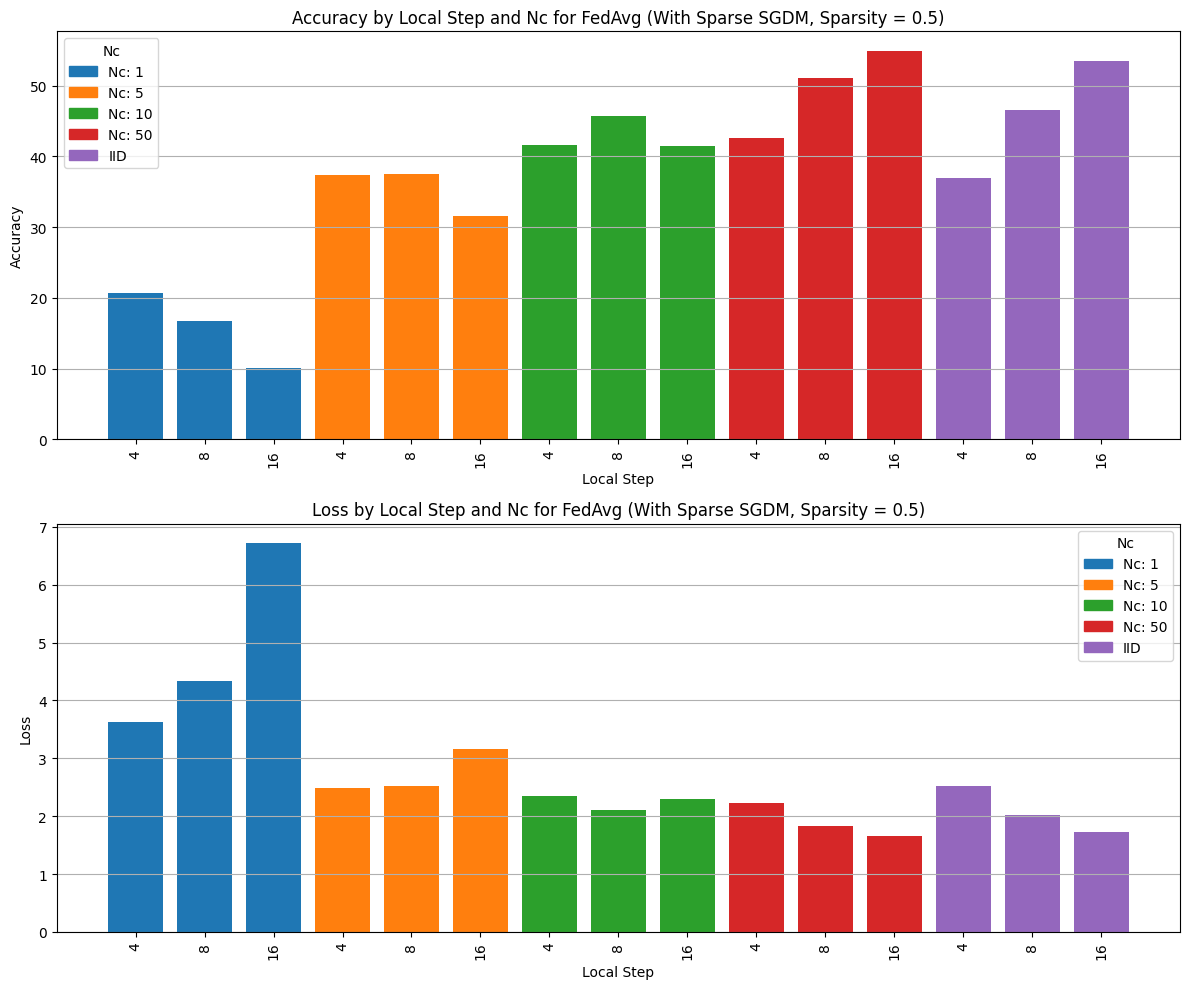

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for FedAvg_noMasking records
fedavg_df = result_df[result_df['aggregation_method'] == 'FedAvg']
fedavg_df = fedavg_df[fedavg_df['sparsity'] == 0.5]


# Sort by Nc and then local_step
fedavg_df = fedavg_df.sort_values(by=['Nc', 'local_step'])

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Get unique Nc values for coloring
unique_ncs = fedavg_df['Nc'].unique()
color_map = dict(zip(unique_ncs, sns.color_palette('tab10', len(unique_ncs))))

# Plot Accuracy
ax1 = axes[0]
colors_accuracy = fedavg_df['Nc'].map(color_map)
bars1 = ax1.bar(np.arange(len(fedavg_df)), fedavg_df['accuracy'], color=colors_accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Local Step and Nc for FedAvg (With Sparse SGDM, Sparsity = 0.5)')
ax1.set_xticks(np.arange(len(fedavg_df))) # Set x-ticks for each bar
ax1.set_xticklabels(fedavg_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax1.set_xlabel('Local Step')
ax1.grid(axis='y')

# Add custom legend labels
legend_labels = [f'Nc: {int(nc)}' if nc != 100 else 'IID' for nc in unique_ncs]
legend_handles = [plt.Rectangle((0,0),1,1, color=color_map[nc]) for nc in unique_ncs]
ax1.legend(legend_handles, legend_labels, title="Nc")


# Plot Loss
ax2 = axes[1]
colors_loss = fedavg_df['Nc'].map(color_map)
bars2 = ax2.bar(np.arange(len(fedavg_df)), fedavg_df['loss'], color=colors_loss)
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Local Step and Nc for FedAvg (With Sparse SGDM, Sparsity = 0.5)')
ax2.set_xticks(np.arange(len(fedavg_df))) # Set x-ticks for each bar
ax2.set_xticklabels(fedavg_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax2.set_xlabel('Local Step')
ax2.grid(axis='y')

# Add custom legend labels
ax2.legend(legend_handles, legend_labels, title="Nc")


plt.tight_layout()
# plt.show()
plt.savefig("accuracy and Loss by Local Step and Nc for FedAvg (With Sparse SGDM, Sparsity = 0.5).pdf")

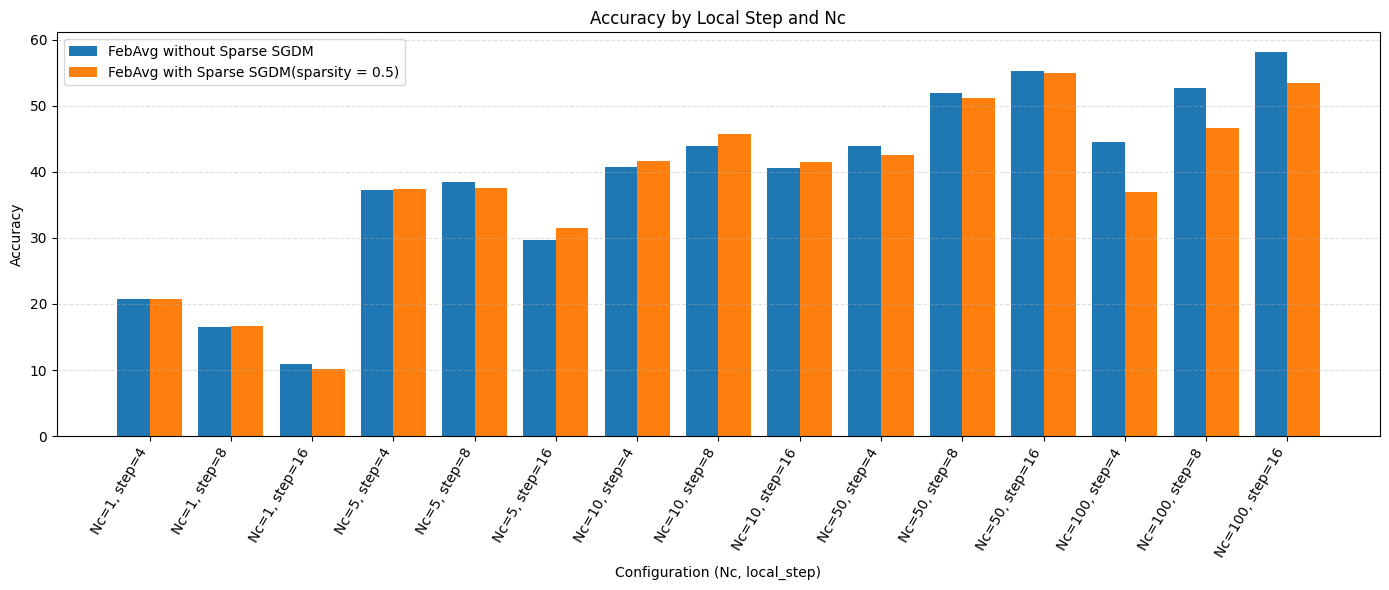

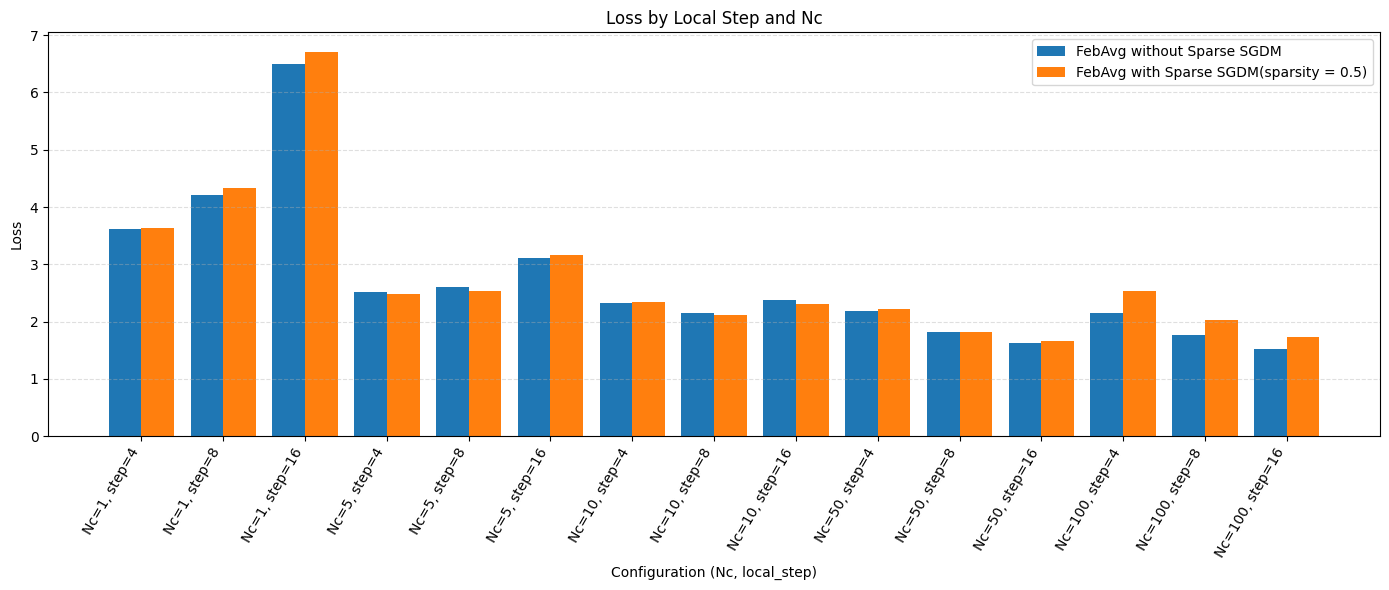

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Build the two source DataFrames (same filtering you used) ----
fedavg_df = result_df[(result_df['aggregation_method'] == 'FedAvg') & (result_df['sparsity'] == 0.5)].copy()
fedavg_nomasking_df = result_df[result_df['aggregation_method'] == 'FedAvg_noMasking'].copy()

# Keep only the columns we need and tag the method
fedavg_df = fedavg_df[['Nc', 'local_step', 'accuracy', 'loss']].copy()
fedavg_df['method'] = 'FedAvg'

fedavg_nomasking_df = fedavg_nomasking_df[['Nc', 'local_step', 'accuracy', 'loss']].copy()
fedavg_nomasking_df['method'] = 'FedAvg_noMasking'

# Combine
combined = pd.concat([fedavg_df, fedavg_nomasking_df], ignore_index=True)

# Optional: enforce integer formatting for nicer labels (if they’re floats)
for col in ['Nc', 'local_step']:
    if pd.api.types.is_float_dtype(combined[col]):
        combined[col] = combined[col].astype(int)

# Sort by Nc then local_step for consistent ordering
combined = combined.sort_values(by=['Nc', 'local_step', 'method'])

# Build the category order (all unique (Nc, local_step) pairs)
cats = combined[['Nc', 'local_step']].drop_duplicates().to_records(index=False).tolist()

# Helper to fetch y-values aligned to category order for a given metric+method
def y_for(method, metric):
    # map (Nc, local_step) -> metric value
    dd = combined[combined['method'] == method].set_index(['Nc', 'local_step'])[metric].to_dict()
    ys = [dd.get((nc, ls), np.nan) for (nc, ls) in cats]  # np.nan will be skipped in bar height
    return np.array(ys, dtype=float)

# Nice x labels
x_labels = [f"Nc={nc}, step={ls}" for (nc, ls) in cats]
x = np.arange(len(cats))
bar_w = 0.4

def grouped_bar(metric, title_y):
    fig = plt.figure(figsize=(14, 6))
    # left/right offsets for the two methods
    y_nomask = y_for('FedAvg_noMasking', metric)
    y_mask   = y_for('FedAvg', metric)

    # Plot: no explicit colors (lets Matplotlib pick)
    plt.bar(x - bar_w/2, y_nomask, width=bar_w, label='FedAvg_noMasking')
    plt.bar(x + bar_w/2, y_mask,   width=bar_w, label='FedAvg')

    plt.xticks(x, x_labels, rotation=60, ha='right')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Configuration (Nc, local_step)')
    plt.title(f'{title_y} by Local Step and Nc')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(["FebAvg without Sparse SGDM", "FebAvg with Sparse SGDM(sparsity = 0.5)"  ])
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"FebAvg without Sparse SGDM vs FebAvg with Sparse SGDM-{title_y}.pdf")

# ---- 2) Make the two comparison plots ----
grouped_bar('accuracy', 'Accuracy')
grouped_bar('loss', 'Loss')


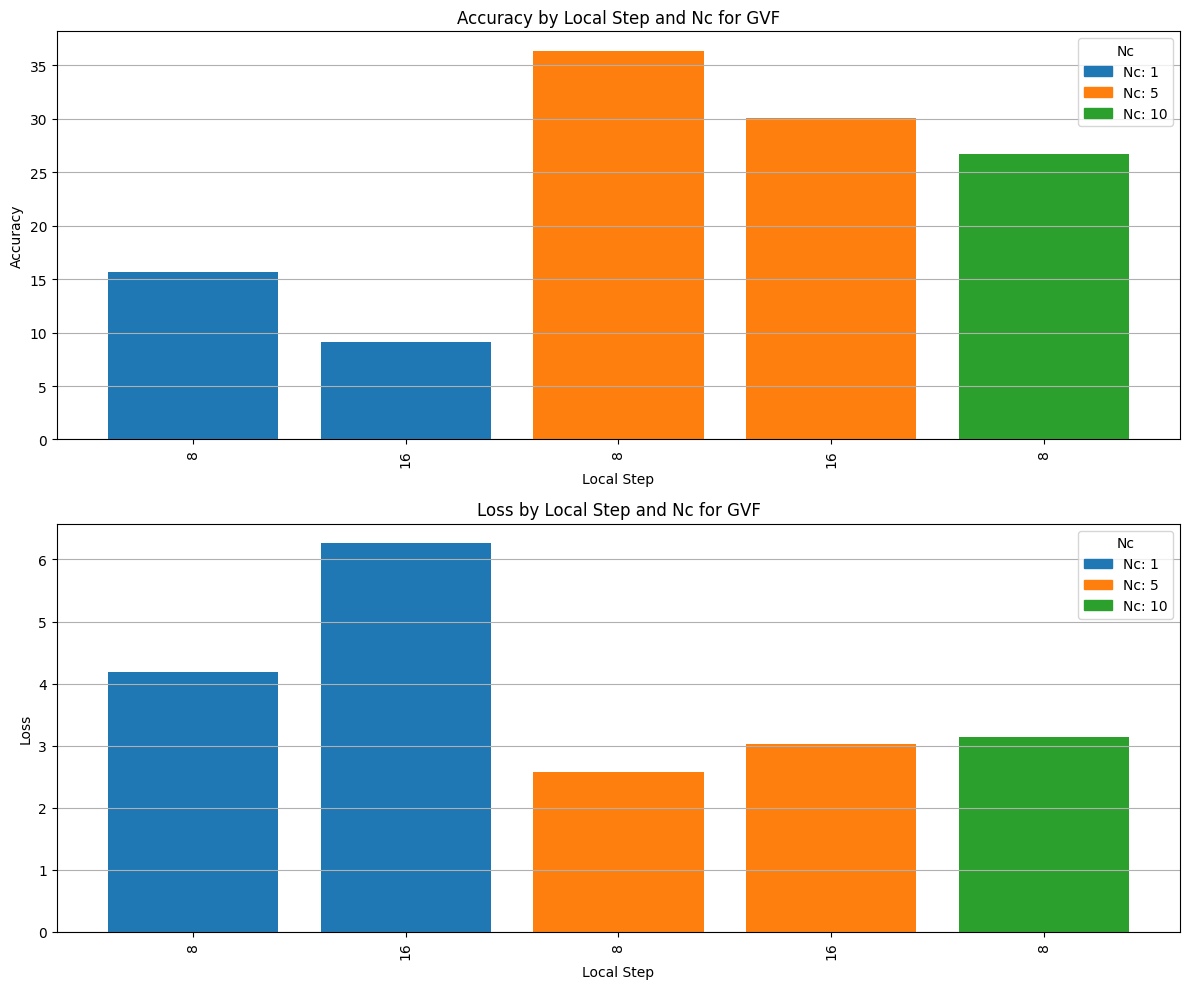

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for FedAvg_noMasking records
globalmasking_df = result_df[result_df['aggregation_method'] == 'FedAvg_globalmasking']

# Sort by Nc and then local_step
globalmasking_df = globalmasking_df.sort_values(by=['Nc', 'local_step'])

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Get unique Nc values for coloring
unique_ncs = globalmasking_df['Nc'].unique()
color_map = dict(zip(unique_ncs, sns.color_palette('tab10', len(unique_ncs))))

# Plot Accuracy
ax1 = axes[0]
colors_accuracy = globalmasking_df['Nc'].map(color_map)
bars1 = ax1.bar(np.arange(len(globalmasking_df)), globalmasking_df['accuracy'], color=colors_accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Local Step and Nc for GVF')
ax1.set_xticks(np.arange(len(globalmasking_df))) # Set x-ticks for each bar
ax1.set_xticklabels(globalmasking_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax1.set_xlabel('Local Step')
ax1.grid(axis='y')

# Add custom legend labels
legend_labels = [f'Nc: {int(nc)}' if nc != 100 else 'IID' for nc in unique_ncs]
legend_handles = [plt.Rectangle((0,0),1,1, color=color_map[nc]) for nc in unique_ncs]
ax1.legend(legend_handles, legend_labels, title="Nc")


# Plot Loss
ax2 = axes[1]
colors_loss = globalmasking_df['Nc'].map(color_map)
bars2 = ax2.bar(np.arange(len(globalmasking_df)), globalmasking_df['loss'], color=colors_loss)
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Local Step and Nc for GVF')
ax2.set_xticks(np.arange(len(globalmasking_df))) # Set x-ticks for each bar
ax2.set_xticklabels(globalmasking_df['local_step'].values, rotation=90) # Set x-labels to local_step
ax2.set_xlabel('Local Step')
ax2.grid(axis='y')

# Add custom legend labels
ax2.legend(legend_handles, legend_labels, title="Nc")


plt.tight_layout()
# plt.show()
plt.savefig("accuracy and Loss by Local Step and Nc for GVF.pdf")

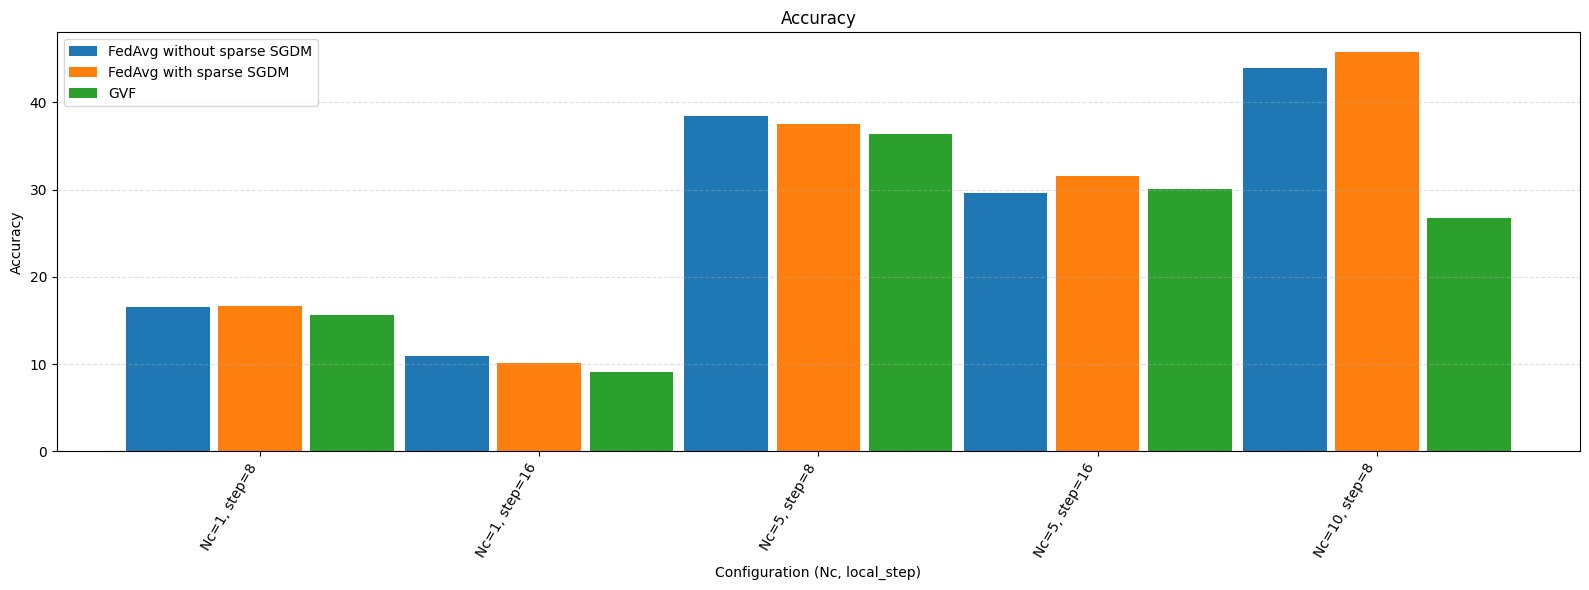

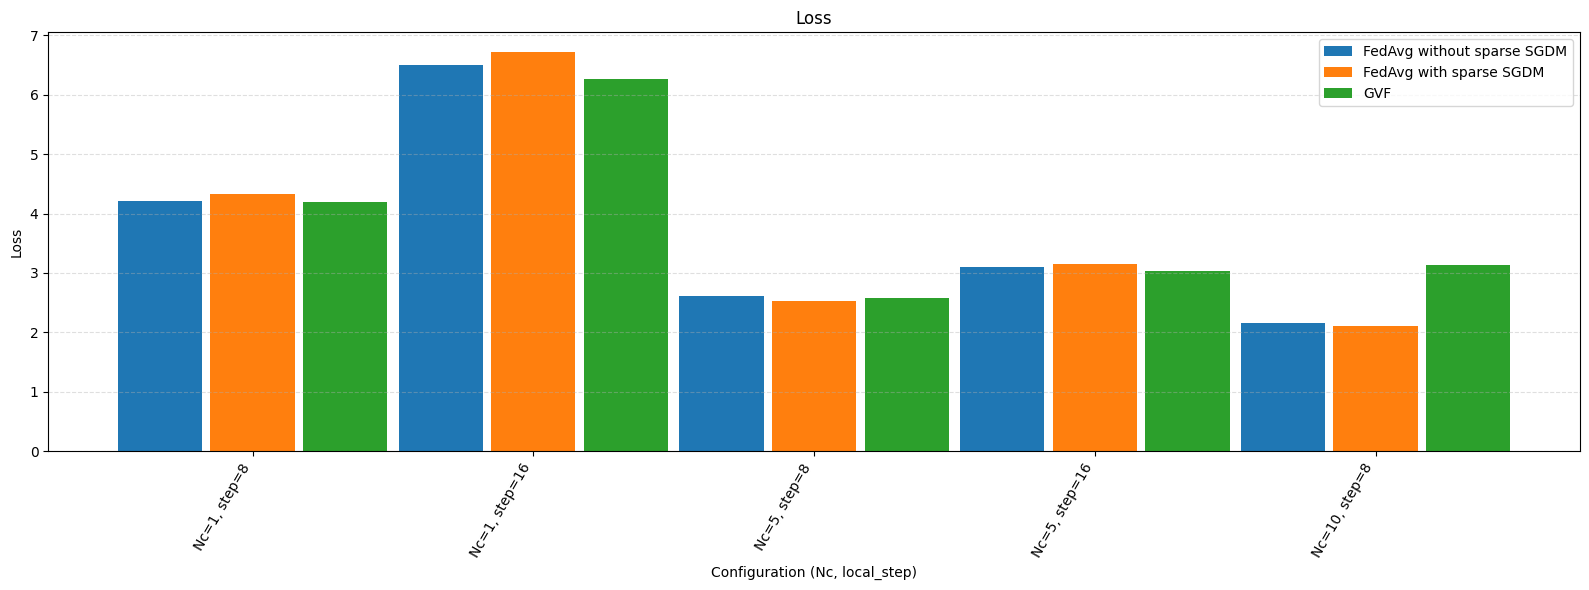

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- If you don't already have these three DFs, build them from result_df ---
# fedavg_df = result_df[(result_df['aggregation_method'] == 'FedAvg') & (result_df['sparsity'] == 0.5)].copy()
# fedavg_nomasking_df = result_df[result_df['aggregation_method'] == 'FedAvg_noMasking'].copy()
# globalmasking_df = result_df[result_df['aggregation_method'] == 'GlobalMasking'].copy()

# Keep only necessary columns + tag method
def prep(df, name):
    df = df[['Nc', 'local_step', 'accuracy', 'loss']].copy()
    # (optional) cast to int if these are floats
    for col in ['Nc', 'local_step']:
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(int)
    df['method'] = name
    return df

fedavg_df_p   = prep(fedavg_df, 'FedAvg')
nomask_df_p   = prep(fedavg_nomasking_df, 'FedAvg_noMasking')
global_df_p   = prep(globalmasking_df, 'GlobalMasking')

# --- Build intersection of categories present in ALL THREE ---
def catset(df):
    return set(df[['Nc', 'local_step']].itertuples(index=False, name=None))

intersect_cats = catset(fedavg_df_p) & catset(nomask_df_p) & catset(global_df_p)

# Filter each df to intersection only
fedavg_df_p   = fedavg_df_p[fedavg_df_p[['Nc','local_step']].apply(tuple, axis=1).isin(intersect_cats)]
nomask_df_p   = nomask_df_p[nomask_df_p[['Nc','local_step']].apply(tuple, axis=1).isin(intersect_cats)]
global_df_p   = global_df_p[global_df_p[['Nc','local_step']].apply(tuple, axis=1).isin(intersect_cats)]

# Combine and sort for stable ordering
combined = pd.concat([fedavg_df_p, nomask_df_p, global_df_p], ignore_index=True)
combined = combined.sort_values(by=['Nc', 'local_step', 'method'])

# Ordered category list
cats = sorted(list(intersect_cats))  # list of (Nc, local_step)
x_labels = [f"Nc={nc}, step={ls}" for (nc, ls) in cats]
x = np.arange(len(cats))

# Helper to get metric values aligned to cats
def y_for(method, metric):
    dd = combined[combined['method'] == method].set_index(['Nc','local_step'])[metric].to_dict()
    return np.array([dd[(nc, ls)] for (nc, ls) in cats], dtype=float)

methods = ['FedAvg_noMasking', 'FedAvg', 'GlobalMasking']
offsets = [-0.33, 0.0, 0.33]  # three bars around each x
bar_w = 0.3

def grouped_bar(metric, title_y):
    fig = plt.figure(figsize=(16, 6))
    for m, off in zip(methods, offsets):
        y = y_for(m, metric)
        plt.bar(x + off, y, width=bar_w, label=m)
    plt.xticks(x, x_labels, rotation=60, ha='right')
    plt.ylabel(title_y)
    plt.xlabel('Configuration (Nc, local_step)')
    plt.title(f'{title_y}')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(['FedAvg without sparse SGDM', 'FedAvg with sparse SGDM', 'GVF'])
    plt.tight_layout()
    plt.savefig(f"FedAvg without sparse SGDM vs FedAvg with sparse SGDM vs GVF-{title_y}.pdf")
    # plt.show()

# --- Plot both metrics ---
grouped_bar('accuracy', 'Accuracy')
grouped_bar('loss', 'Loss')


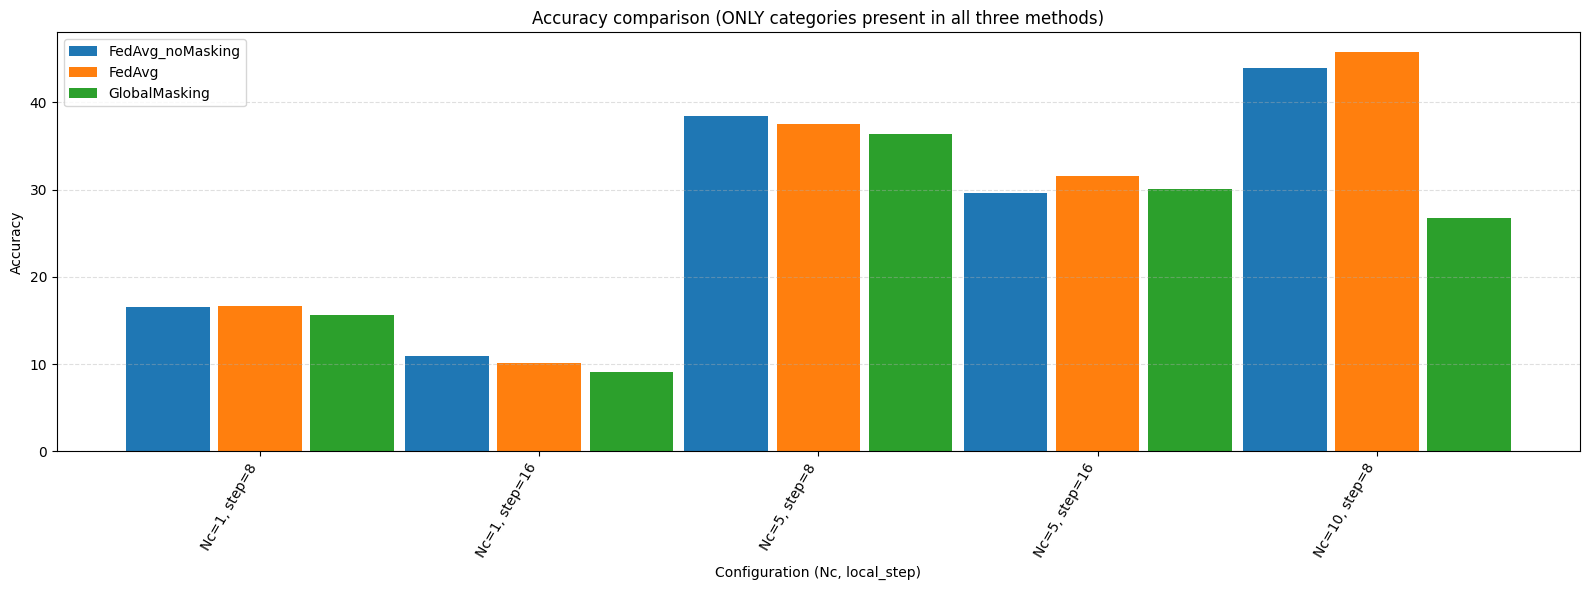

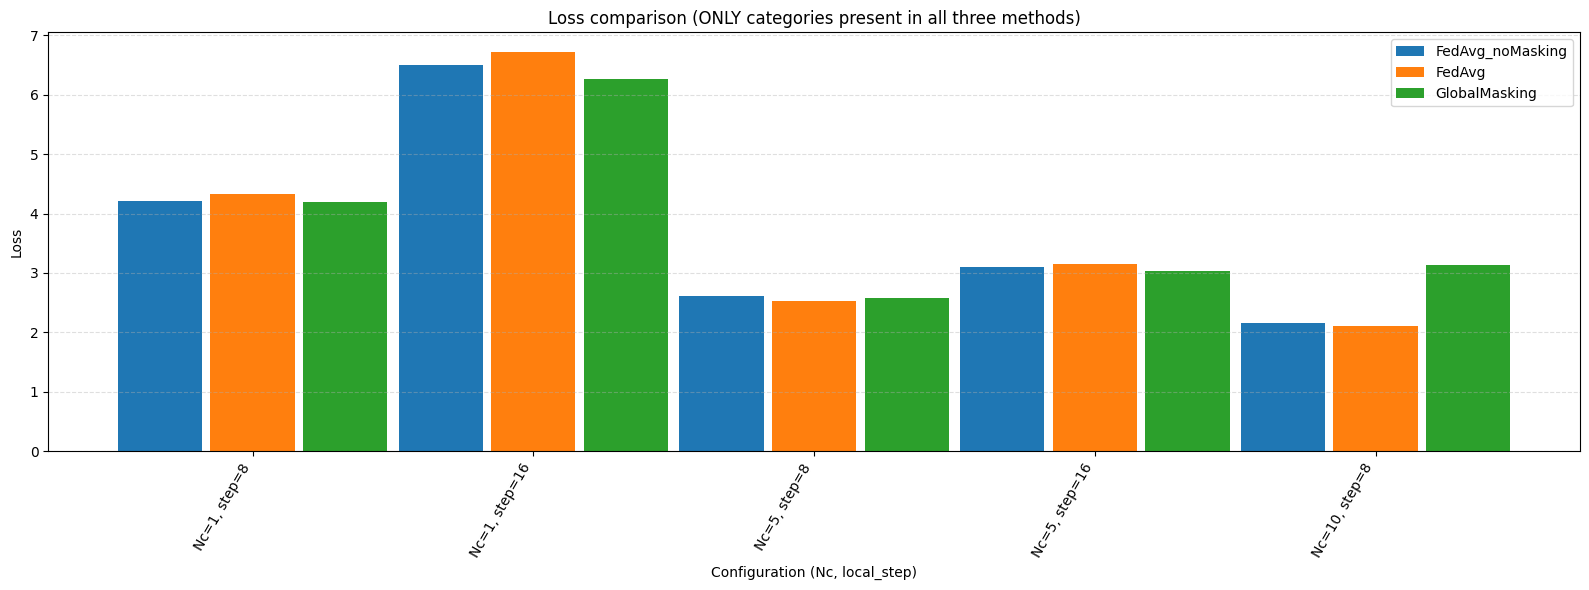

In [128]:
seq_lst = []
exception= ["3b16bcde-abf5-4c87-b9bb-ef2827a59c6d",'1f7efd38-b55a-458c-9478-b763895e5acc']
for i in range(len( globalmasking_df)):
  groups = []
  record = globalmasking_df.iloc[i]
  no_mask_filter =   (result_df['aggregation_method'] == "FedAvg_noMasking") &  (result_df['Nc'] == record['Nc']) & (result_df['local_step'] == record['local_step'])
  fedavg_filter =   (result_df['aggregation_method'] == "FedAvg") &  (result_df['Nc'] == record['Nc']) & (result_df['local_step'] == record['local_step'])  & (result_df["sparsity"] == 0.5)

  groups.append(get_model_squence(global_df, record['seed_model_name']))

  # print(i, result_df[no_mask_filter]["seed_model_name"].values[0])
  # print(result_df[fedavg_filter]["seed_model_name"])

  groups.append(get_model_squence(global_df,result_df[no_mask_filter]["seed_model_name"].values[0]))
  groups.append(get_model_squence(global_df,result_df[fedavg_filter]["seed_model_name"].values[0]))

  seq_lst.append(groups)
  print(len(groups))
print(len(seq_lst))

print(seq_lst[0][0].columns)


3
3
3
3
3
5
Index(['backbone', 'num_of_clients', 'splitting_method', 'Nc',
       'num_local_steps', 'aggregation_method', 'Measurement_criteria',
       'accuracy', 'loss', 'size_of_dataset', 'train_test_ratio',
       'round_number', 'num_of_participants', 'model_name',
       'prev_global_model_name', 'contributors', 'path',
       'momentum_vector_path', 'path_to_subsets', 'path_to_class_combs',
       'time'],
      dtype='object')


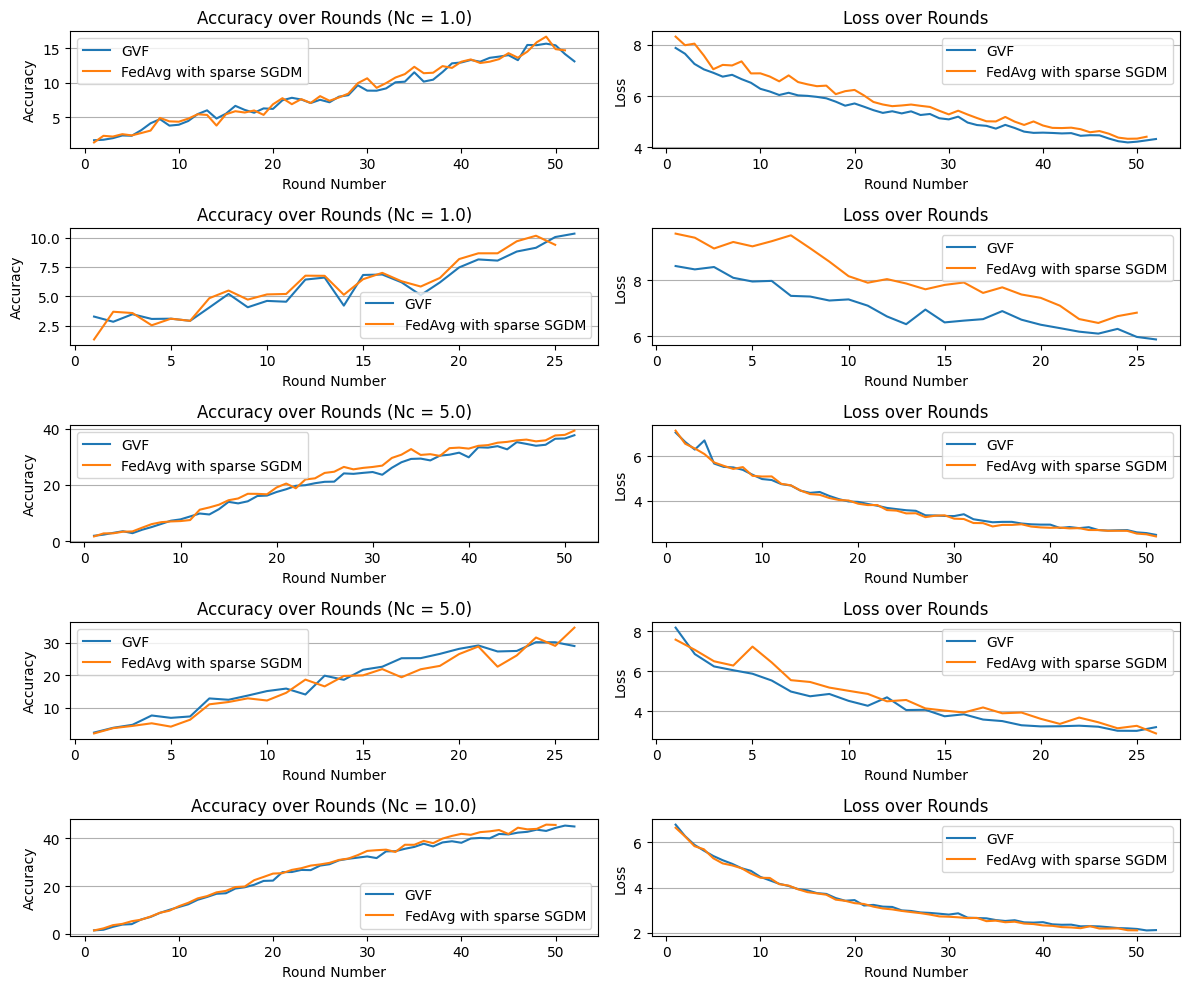

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(12, 10))
for j  in range(len(seq_lst)):
  for i, df in enumerate(seq_lst[j]):
      if df['aggregation_method'].values[-1] == 'FedAvg_noMasking': continue
      sns.lineplot(data=df, x='round_number', y='accuracy', ax=axes[j][0], label="FedAvg with sparse SGDM" if df['aggregation_method'].values[-1] == "FedAvg" else "GVF" )
      sns.lineplot(data=df, x='round_number', y='loss', ax=axes[j][1],label="FedAvg with sparse SGDM" if df['aggregation_method'].values[-1] == "FedAvg" else "GVF" )
      Nc = df['Nc'].values[-1]

  axes[j][0].set_ylabel('Accuracy')
  axes[j][0].set_title(f'Accuracy over Rounds (Nc = {Nc})')
  axes[j][0].set_xlabel('Round Number')
  axes[j][0].grid(axis='y')
  axes[j][0].legend()

  axes[j][1].set_ylabel('Loss')
  axes[j][1].set_title('Loss over Rounds')
  axes[j][1].set_xlabel('Round Number')
  axes[j][1].grid(axis='y')
  axes[j][1].legend()

plt.tight_layout()
# plt.show()
plt.savefig("accuracy and Loss over Rounds for FedAvg with sparse SGDM vs GVF.pdf")